In [1]:
import nltk
import pandas as pd
import numpy as np
import re
import string
import spacy
import sklearn
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [2]:
### Import data and setup dataframe ###

# usage: specify file location
filepath = '../Data_git_ignore/1mio-raw.csv'
# filepath = '../Data_git_ignore/clean-100k.csv'

# Create df for the entire file
entire_df = pd.read_csv(filepath, index_col = [0])

### Below are overall integrity cleaning ###

# Drop non-numeric id's
entire_df['id'] = pd.to_numeric(entire_df['id'], errors = 'coerce', downcast = 'integer')
entire_df.dropna(subset=['id'], inplace = True)

# Set id to int
entire_df['id'] = entire_df['id'].astype(int)

# content has to be unique
entire_df.drop_duplicates(['content'], inplace = True)

# Drop rows wiht type-nan´
entire_df = entire_df[entire_df['type'].notna()]

# Create type_id column
entire_df['type_id'] = entire_df.groupby(['type']).ngroup()

entire_df

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source,type_id
0,2,express.co.uk,rumor,https://www.express.co.uk/news/science/738402/...,"Life is an illusion, at least on a quantum lev...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Is life an ILLUSION? Researchers prove 'realit...,Sean Martin,NaN,[''],THE UNIVERSE ceases to exist when we are not l...,NaN,NaN,NaN,8
1,6,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,"Unfortunately, he hasn’t yet attacked her for ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN,4
2,7,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,The Los Angeles Police Department has been den...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN,4
3,8,barenakedislam.com,hate,http://barenakedislam.com/2017/12/24/more-winn...,The White House has decided to quietly withdra...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"MORE WINNING! Israeli intelligence source, DEB...","Cleavis Nowell, Cleavisnowell, Clarence J. Fei...",NaN,[''],NaN,NaN,NaN,NaN,4
4,9,barenakedislam.com,hate,http://barenakedislam.com/2017/12/25/oh-trump-...,“The time has come to cut off the tongues of t...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"“Oh, Trump, you coward, you just wait, we will...","F.N. Lehner, Don Spilman, Clarence J. Feinour,...",NaN,[''],NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,1170082,wikileaks.org,unreliable,https://www.wikileaks.org/plusd/cables/1974ATO...,Raw content\n\nPAGE 01 NATO 05116 01 OF 02 201...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Cable: 1974ATO05116,NaN,NaN,[''],NaN,View Tags,NaN,NaN,11
9906,1170093,wikileaks.org,unreliable,https://www.wikileaks.org/plusd/cables/1976ABU...,Raw content\n\nCONFIDENTIAL PAGE 01 ABU DH 000...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Cable: 1976ABUDH00021,NaN,NaN,[''],NaN,View Tags,NaN,NaN,11
9913,1170100,wikileaks.org,unreliable,https://www.wikileaks.org/plusd/cables/1976ANK...,Raw content\n\nCONFIDENTIAL PAGE 01 ANKARA 019...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Cable: 1976ANKARA01989,NaN,NaN,[''],NaN,View Tags,NaN,NaN,11
9923,1170110,wikileaks.org,unreliable,https://www.wikileaks.org/plusd/cables/1976ROM...,Raw content\n\nLIMITED OFFICIAL USE PAGE 01 RO...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Cable: 1976ROME16372,NaN,NaN,[''],NaN,View Tags,NaN,NaN,11


In [5]:
entire_df.reset_index(inplace = True, drop = True)

2047      1
220353    1
201928    1
224455    1
222406    1
         ..
222009    1
224056    1
201527    1
203574    1
0         1
Length: 628202, dtype: int64

In [6]:
### SELECT SIZE OF -> sub-dataset ###

# This can generate a dataset with random purmutation and a max size for each type(can be smaller if desired max is not possible)

# max size for type
max_size = 300
# Labels to include - ['fake', 'satire', 'bias', 'conspiracy', 'state', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable'] - all labels
use_types = ['fake', 'satire', 'bias', 'conspiracy', 'junksci', 'hate', 'rumor', 'clickbait', 'unreliable', 'political', 'reliable']
# Random seed
rnd = 1

# initialize dataframes
df = pd.DataFrame(columns = entire_df.columns)

# add type to test splits
for t in use_types:

    # type size
    type_size = entire_df['type'].loc[entire_df['type'] == t].value_counts().min()

    # set size of type slice
    if type_size < max_size:
        tmp = entire_df.loc[entire_df['type'] == t].sample(n = type_size, random_state=rnd)
    else:
        tmp = entire_df.loc[entire_df['type'] == t].sample(n = max_size, random_state=rnd)
    
    # add tmp to dataframes
    df = pd.concat([df, tmp])
    
    # print split shape
    print("=>", t, tmp.shape)

print("\n[Final sub-dataset]\nwhole ==>", df.shape)

=> fake (300, 17)
=> satire (300, 17)
=> bias (300, 17)
=> conspiracy (300, 17)
=> junksci (300, 17)
=> hate (300, 17)
=> rumor (300, 17)
=> clickbait (300, 17)
=> unreliable (300, 17)
=> political (300, 17)
=> reliable (300, 17)

[Final sub-dataset]
whole ==> (3300, 17)


In [8]:
#del entire_df

In [6]:
### REMOVE AND REPLACE -> NaN/Empty elmements ###

# Remove rows where columns are NaN
df.dropna(subset=['title'])

# Replace NaN-elements with 'NULL'
df = df.fillna('NULL')

# Replace "['']" - these are NaN 
regex = r"\[''\]"
df['meta_keywords'] = df['meta_keywords'].replace(to_replace=regex, value='NULL', regex=True)

# Replace '_' or '' (empty str) from "string-like" columns - these are NaN
regex = r"^$|^ +"
columns = ['domain', 'type', 'url', 'content', 'title', 'authors', 'keywords', 'meta_description', 'tags', 'summary', 'source']
df[columns] = df[columns].replace(to_replace=regex, value='NULL', regex=True)

In [7]:
df['type_id'] = df.groupby(['type']).ngroup()

In [8]:
# # working with content as a series
series_content = df['content']

### Order matters - (not final order of pipeline)
### Overall preprocessing

# lower_cast - NEEDED? - DONE by many libs
%time print("\n (lower_cast)"); series_content = series_content.str.lower()

### replace [name] with tokens in text ###

# Email_replace
regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
%time print("\n (Email_replace)"); series_content = series_content.replace(to_replace=regexEmail, value=' EMAIL ', regex=True)

# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
%time print("\n (URL_replace)"); series_content = series_content.replace(to_replace=regexURL, value=' URL ', regex=True)

# HTML_replace
regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
%time print("\n (HTML_replace)"); series_content = series_content.replace(to_replace=regexHTML, value=' HTML ', regex=True)

# Date_replace - NOT DONE
# - name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
# - day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
# - year         ([12][0-9]{3})         - Years from 1000 to 2999
regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
%time print("\n (Date_replace)"); series_content = series_content.replace(to_replace=regexDate, value=' DATE ', regex=True)

# Number_replace
regexNum = r"[0-9][0-9,\.]+" # nums with [0-9] and [,.]
%time print("\n (Number_replace)"); series_content = series_content.replace(to_replace=regexNum, value=' NUM ', regex=True)

### string removal functions ###

# Punctuation_remove
regexPunkt = r"[!“”\"#$%&()*+,\-–.…\/:;<=>?@[\\\]^_`{|}~'\’\'»]" # also removes: " ' " which means ie. it's -> its - remove \' from regwex if not needed
%time print("\n (Punctuation_remove)"); series_content = series_content.replace(to_replace=regexPunkt, value='', regex=True)

# whitespace_remove
regexWhiteSpace = r"\s+|\\n+"
%time print("\n (whitespace_remove)"); series_content = series_content.replace(to_replace=regexWhiteSpace, value=' ', regex=True)

# # Non_ASCII_remove - Maybe a step too much
# %time print("\n (Non_ASCII_remove)"); series_content = series_content.str.encode('ascii', 'ignore').str.decode('ascii')

# After all steps
print("\n (Done cleaning)")


 (lower_cast)
CPU times: user 120 ms, sys: 519 ms, total: 639 ms
Wall time: 2.27 s

 (Email_replace)
CPU times: user 722 ms, sys: 12.6 ms, total: 734 ms
Wall time: 802 ms

 (URL_replace)
CPU times: user 2.67 s, sys: 62.1 ms, total: 2.73 s
Wall time: 2.94 s

 (HTML_replace)
CPU times: user 12 ms, sys: 286 µs, total: 12.2 ms
Wall time: 12.3 ms

 (Date_replace)
CPU times: user 4.4 s, sys: 62.1 ms, total: 4.46 s
Wall time: 4.69 s

 (Number_replace)
CPU times: user 194 ms, sys: 47.5 ms, total: 241 ms
Wall time: 376 ms

 (Punctuation_remove)
CPU times: user 259 ms, sys: 14.3 ms, total: 274 ms
Wall time: 311 ms

 (whitespace_remove)
CPU times: user 1.26 s, sys: 28.7 ms, total: 1.29 s
Wall time: 1.41 s

 (Done cleaning)


In [9]:
dfRaw = pd.DataFrame({'content' : series_content.values, 'type' : df.type.values, 'type_id' : df.type_id.values})

In [10]:
# This can generate a dataset with random purmutation and a max size for each type(can be smaller if desired max is not possible)

# max size for type
max_size = 300
# traning_set ratio - splits data into traning=ratio,  test and validate=(1-ratio)/2 ex. train=80%, test=10%, validate=10%
ratio=0.8
# Labels to include - ['fake', 'satire', 'bias', 'conspiracy', 'state', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable'] - all labels
use_types = ['fake', 'satire', 'bias', 'conspiracy', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable', 'rumor']
# Random seed
rnd = 1

# initialize dataframes
trainRaw    = pd.DataFrame(columns = dfRaw.columns)
testRaw     = pd.DataFrame(columns = dfRaw.columns)

# add type to test splits
for t in use_types:

    # type size
    type_size = dfRaw['type'].loc[dfRaw['type'] == t].value_counts().min()

    # set size of type slice
    if type_size < max_size:
        tmp = dfRaw.loc[dfRaw['type'] == t].sample(n = type_size, random_state=rnd)
    else:
        tmp = dfRaw.loc[dfRaw['type'] == t].sample(n = max_size, random_state=rnd)

    # split current type
    train_tmp, test_tmp = np.split(tmp, [int(ratio * len(tmp))])

    # add tmp to dataframes
    trainRaw    = pd.concat([trainRaw, train_tmp])
    testRaw     = pd.concat([testRaw, test_tmp])
    
    # print split shape
    print("=>", t, tmp.shape, train_tmp.shape, test_tmp.shape)

print("\n[Final split]\ntrainRaw, testRaw==>", trainRaw.shape, testRaw.shape)

=> fake (300, 3) (240, 3) (60, 3)
=> satire (300, 3) (240, 3) (60, 3)
=> bias (300, 3) (240, 3) (60, 3)
=> conspiracy (300, 3) (240, 3) (60, 3)
=> junksci (300, 3) (240, 3) (60, 3)
=> hate (300, 3) (240, 3) (60, 3)
=> clickbait (300, 3) (240, 3) (60, 3)
=> unreliable (300, 3) (240, 3) (60, 3)
=> political (300, 3) (240, 3) (60, 3)
=> reliable (300, 3) (240, 3) (60, 3)
=> rumor (300, 3) (240, 3) (60, 3)

[Final split]
trainRaw, testRaw==> (2640, 3) (660, 3)


In [11]:
#train.set_index('id', inplace = True)
from sklearn.utils import shuffle
trainRaw = shuffle(trainRaw, random_state = 1)
testRaw = shuffle(testRaw, random_state = 1)
trainRaw.reset_index(inplace = True, drop = True)
testRaw.reset_index(inplace = True, drop = True)

In [12]:
#Tokenize cleaned content
content_tokenize_series = series_content.str.split()
#change df-content to the tokenized version
df['content'] = content_tokenize_series

In [14]:
# This can generate a dataset with random purmutation and a max size for each type(can be smaller if desired max is not possible)

# max size for type
max_size = 300
# traning_set ratio - splits data into traning=ratio,  test and validate=(1-ratio)/2 ex. train=80%, test=10%, validate=10%
ratio=0.8
# Labels to include - ['fake', 'satire', 'bias', 'conspiracy', 'state', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable'] - all labels
use_types = ['fake', 'satire', 'bias', 'conspiracy', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable', 'rumor']
# Random seed
rnd = 1

# initialize dataframes
train    = pd.DataFrame(columns = df.columns)
test     = pd.DataFrame(columns = df.columns)

# add type to test splits
for t in use_types:

    # type size
    type_size = df['type'].loc[df['type'] == t].value_counts().min()

    # set size of type slice
    if type_size < max_size:
        tmp = df.loc[df['type'] == t].sample(n = type_size, random_state=rnd)
    else:
        tmp = df.loc[df['type'] == t].sample(n = max_size, random_state=rnd)

    # split current type
    train_tmp, test_tmp = np.split(tmp, [int(ratio * len(tmp))])

    # add tmp to dataframes
    train    = pd.concat([train, train_tmp])
    test     = pd.concat([test, test_tmp])
    
    # print split shape
    print("=>", t, tmp.shape, train_tmp.shape, test_tmp.shape)

print("\n[Final split]\ntrain, test==>", train.shape, test.shape)

=> fake (300, 17) (240, 17) (60, 17)
=> satire (300, 17) (240, 17) (60, 17)
=> bias (300, 17) (240, 17) (60, 17)
=> conspiracy (300, 17) (240, 17) (60, 17)
=> junksci (300, 17) (240, 17) (60, 17)
=> hate (300, 17) (240, 17) (60, 17)
=> clickbait (300, 17) (240, 17) (60, 17)
=> unreliable (300, 17) (240, 17) (60, 17)
=> political (300, 17) (240, 17) (60, 17)
=> reliable (300, 17) (240, 17) (60, 17)
=> rumor (300, 17) (240, 17) (60, 17)

[Final split]
train, test==> (2640, 17) (660, 17)


In [15]:
import gensim 
from gensim.models.doc2vec import TaggedDocument, Doc2Vec 

In [16]:
#from sklearn.utils import shuffle
train = shuffle(train, random_state = 1)
test = shuffle(test, random_state = 1)
train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)

In [17]:
contTok = train.content
train_typeLst = train.type_id.tolist()

In [18]:
testTok = test.content
test_typeLst = test.type_id.tolist()

In [156]:
testTok

0        [there, is, no, denying, that, japanese, game,...
1        [julian, and, adrian, riester, were, known, as...
2        [back, in, the, summer, of, NUM, when, the, ec...
3        [the, democratic, partys, long, sojourn, into,...
4        [an, overview, of, rapture, and, millennial, v...
                               ...                        
10618    [beijing, —, chinese, are, embracing, christia...
10619    [personally, i, see, this, tentatively, as, a,...
10620    [evidence, continues, to, mount, for, ninth, p...
10621    [by, mark, twain, pictured, first, published, ...
10622    [hli, spain, honored, by, leading, spanish, ma...
Name: content, Length: 10623, dtype: object

In [33]:
documents = [TaggedDocument(contTok, [i]) for i, contTok in enumerate(contTok)]

In [34]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [35]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [36]:
model2 = Doc2Vec(documents, vector_size = 200, min_count = 3, dm = 0, epochs=15, workers = cores)

rds/s, in_qsize 7, out_qsize 0
2020-06-10 21:34:52,676 : INFO : EPOCH 1 - PROGRESS: at 44.72% examples, 438356 words/s, in_qsize 7, out_qsize 0
2020-06-10 21:34:53,685 : INFO : EPOCH 1 - PROGRESS: at 46.36% examples, 433564 words/s, in_qsize 7, out_qsize 0
2020-06-10 21:34:54,687 : INFO : EPOCH 1 - PROGRESS: at 48.35% examples, 432881 words/s, in_qsize 7, out_qsize 0
2020-06-10 21:34:55,688 : INFO : EPOCH 1 - PROGRESS: at 50.49% examples, 434947 words/s, in_qsize 7, out_qsize 0
2020-06-10 21:34:56,698 : INFO : EPOCH 1 - PROGRESS: at 52.53% examples, 434795 words/s, in_qsize 7, out_qsize 0
2020-06-10 21:34:57,718 : INFO : EPOCH 1 - PROGRESS: at 55.03% examples, 436382 words/s, in_qsize 7, out_qsize 0
2020-06-10 21:34:58,725 : INFO : EPOCH 1 - PROGRESS: at 56.81% examples, 435160 words/s, in_qsize 7, out_qsize 0
2020-06-10 21:34:59,742 : INFO : EPOCH 1 - PROGRESS: at 58.75% examples, 434892 words/s, in_qsize 7, out_qsize 0
2020-06-10 21:35:00,753 : INFO : EPOCH 1 - PROGRESS: at 61.18% ex

KeyboardInterrupt: 

In [89]:
#Going to use model2 not this model1
#%%time
#model1 = Doc2Vec(documents, vector_size = , min_count = 3, window = 10, epochs=10, workers = 4)

In [ ]:
#Eventuel træn andre modeller herefter:
#%%time
#model2 = Doc2Vec(documents, vector_size = 200, dm = 1, min_count = 3, window = 10, epochs= 10, workers = 4)

In [90]:
model2.most_similar('apple')

2020-06-10 17:33:18,324 : INFO : precomputing L2-norms of word weight vectors


[('nonincrease', 0.31726324558258057),
 ('unchanging', 0.30460652709007263),
 ('fumigation', 0.2858912944793701),
 ('usando', 0.28205808997154236),
 ('palestinianamerican', 0.2792540192604065),
 ('reasoned', 0.2768038511276245),
 ('cyborgs', 0.276467502117157),
 ('humanly', 0.2712938189506531),
 ('benghazi', 0.2702161967754364),
 ('determined', 0.26968449354171753)]

In [19]:
model2.docvecs.count

42489

In [134]:
#See types of most similar documents for model2
#for idx in train.type.loc[train.type == 'fake'].index:
sim_labels1 = np.empty(10,dtype='object')
for i in range(len(sim_labels1)):
    sim_labels1[i] = train.type.loc[train.type.index == model2.docvecs.most_similar(42426)[i][0]].values[0]

# amount of articles with given type equal to testing article
np.unique(sim_labels1,return_counts=True)

(array(['bias', 'clickbait', 'conspiracy', 'junksci', 'rumor'],
       dtype=object), array([2, 1, 2, 1, 4]))

In [129]:
#Lookup indeices for articles with certain types
train.type.loc[train.type == 'rumor']

3        rumor
29       rumor
42       rumor
74       rumor
78       rumor
         ...  
42426    rumor
42446    rumor
42455    rumor
42459    rumor
42463    rumor
Name: type, Length: 4000, dtype: object

In [15]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import utils


In [137]:
#Dont use model1
#Model 1 traindata
#train_arrays = np.zeros((model1.docvecs.count,150),dtype="float32")
#train_labels = np.zeros(model1.docvecs.count,dtype="float32")
#for i in range(model1.docvecs.count):
#    train_arrays[i] = model1.docvecs[i]
#    train_labels[i] = train.type_id[i]

In [21]:
#Model 2 traindata:
train_arrays2 = np.zeros((model2.docvecs.count,200),dtype="float32")
train_labels2 = np.zeros(model2.docvecs.count,dtype="float32")
for i in range(model2.docvecs.count):
    train_arrays2[i] = model2.docvecs[i]
    train_labels2[i] = train.type_id[i]

In [153]:
#How infer_vector works:
#token = "this is new sentence".split()
#new_vector = model1.infer_vector(token)
#sims = model1.docvecs.most_similar([new_vector])
#model2.docvecs.most_similar([new_vec])

In [154]:
#Only usable for model1
#Inferring vectors for testdata with model1
#test_arrays = np.zeros((len(test),150),dtype = "float32")
#for i in range(len(test)):
#    test_arrays[i] = model1.infer_vector(testTok[i],steps = 15)   
#test_labels = np.array(test_typeLst,dtype="float32")

#test_arrays = np.zeros((model1.docvecs.count,150),dtype="float32")
#test_labels = np.zeros(model1.docvecs.count,dtype="float32")

In [22]:
%%time
#Inferring vectors for testdata with model2
test_arrays2 = np.zeros((len(test),200),dtype = "float32")
for i in range(len(test)):
    test_arrays2[i] = model2.infer_vector(testTok[i], epochs = 20, alpha = 0.025)   
test_labels = np.array(test_typeLst,dtype="float32")

CPU times: user 5min 21s, sys: 2.76 s, total: 5min 24s
Wall time: 5min 40s


In [163]:
#model1.docvecs.most_similar([test_arrays[200]])

In [164]:
test.type.loc[test.type.index == 3642]

3642    bias
Name: type, dtype: object

In [166]:
#Only usable for model1:
#Find originalarticle types most similar to inferred vector by model1:
#sim_labels = np.empty(10,dtype='object')
#for i in range(len(sim_labels)):
#    sim_labels[i] = train.type.loc[train.type.index == model1.docvecs.most_similar([test_arrays[3642]])#[i][0]].values[0]

#np.unique(sim_labels,return_counts=True)

In [169]:
model2.docvecs.most_similar([test_arrays2[10]])

[(21173, 0.561996340751648),
 (18161, 0.5567409992218018),
 (6174, 0.5457913279533386),
 (20155, 0.5201143622398376),
 (3539, 0.5196638107299805),
 (17432, 0.5107928514480591),
 (8204, 0.5095251202583313),
 (2687, 0.5090910792350769),
 (38659, 0.5087523460388184),
 (15071, 0.5073102712631226)]

In [182]:
#Find originalarticle types most similar to inferred vector by model2:
sim_labels = np.empty(10,dtype='object')
for i in range(len(sim_labels)):
    sim_labels[i] = train.type.loc[train.type.index == model2.docvecs.most_similar([test_arrays2[76]])[i][0]].values[0]

np.unique(sim_labels,return_counts=True)

(array(['bias'], dtype=object), array([10]))

In [178]:
#Get indices for testarticles of a certain type:
test.type.loc[test.type == 'bias'].index

Int64Index([   10,    27,    31,    39,    76,    80,    86,    94,   123,
              136,
            ...
            10507, 10531, 10541, 10571, 10573, 10588, 10591, 10608, 10609,
            10618],
           dtype='int64', length=1000)

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
#standardizing data
scaler = StandardScaler()
scaler.fit(train_arrays2)
X_train = scaler.transform(train_arrays2)
X_test = scaler.transform(test_arrays2)

In [26]:
#Now train a logistic classifier:
#can try gridsearch for parameters:
#Logistic = LogisticRegression()
#grid = {"C" :np.logspace(0,4,10), "penalty": ["l1", "l2"]}
#logClf = GridSearchCV(Logistic, grid, cv = 5)
#best_model = logClf.fit(X_train, train_labels)
clfLog = LogisticRegression()
clfLog.fit(X_train, train_labels2)

#classifier.fit(X_train,train_labels)
#classifier.n_iter_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
clfLog.score(X_test, test_labels)

0.6652546361668079

In [28]:
y_true = test_labels
y_pred = clfLog.predict(X_test)

In [29]:
confusion_matrix(y_true,y_pred)

array([[464,  51,  77,  17,  99,  55, 104,  56,  16,  48,  13],
       [ 85, 499,  36,  15,  28,  40,  96,  71,  25,  95,  10],
       [ 82,  40, 531,  32,  61,  73,  82,  28,  11,  49,  11],
       [ 12,  16,  20, 868,  14,  29,  22,   7,   1,  10,   1],
       [ 68,  43,  32,  15, 350,  12,  48,  21,  10,  14,  10],
       [ 31,  36,  48,   9,   7, 788,  20,  16,   4,  39,   2],
       [109, 121,  81,  24,  41,  30, 458,  50,  19,  55,  12],
       [ 61,  63,  10,   4,  25,  28,  42, 718,   7,  39,   3],
       [ 15,   8,   7,   1,   2,   5,   2,   4, 899,  54,   3],
       [ 61,  63,  43,   8,  11,  34,  44,  28,  63, 636,   9],
       [ 18,  31,  13,   6,   7,  13,  29,   4,   3,  20, 856]])

In [36]:
target_names = []
for i in range(11):
    target_names.append(test.type.loc[test.type_id == i].values[0])

In [42]:
y_true = list(map(int,y_true.tolist()))
y_pred = list(map(int,y_pred.tolist()))

AttributeError: 'list' object has no attribute 'tolist'

In [105]:
print(classification_report(y_true, y_pred, target_names = target_names))

precision    recall  f1-score   support

        bias       0.46      0.46      0.46      1000
   clickbait       0.51      0.50      0.51      1000
  conspiracy       0.59      0.53      0.56      1000
        fake       0.87      0.87      0.87      1000
        hate       0.54      0.56      0.55       623
     junksci       0.71      0.79      0.75      1000
   political       0.48      0.46      0.47      1000
    reliable       0.72      0.72      0.72      1000
       rumor       0.85      0.90      0.87      1000
      satire       0.60      0.64      0.62      1000
  unreliable       0.92      0.86      0.89      1000

    accuracy                           0.67     10623
   macro avg       0.66      0.66      0.66     10623
weighted avg       0.66      0.67      0.66     10623



In [109]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X_train,train_labels2)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [117]:
y_sgd_pred = sgd.predict(X_test)

In [123]:
y_sgd_pred = list(map(int,y_sgd_pred.tolist()))

In [122]:
print(classification_report(y_true, y_sgd_pred, target_names = target_names))

precision    recall  f1-score   support

        bias       0.36      0.41      0.38      1000
   clickbait       0.47      0.42      0.44      1000
  conspiracy       0.49      0.54      0.51      1000
        fake       0.83      0.85      0.84      1000
        hate       0.45      0.54      0.49       623
     junksci       0.69      0.74      0.71      1000
   political       0.44      0.31      0.36      1000
    reliable       0.70      0.61      0.65      1000
       rumor       0.90      0.83      0.87      1000
      satire       0.51      0.60      0.55      1000
  unreliable       0.87      0.86      0.86      1000

    accuracy                           0.61     10623
   macro avg       0.61      0.61      0.61     10623
weighted avg       0.61      0.61      0.61     10623



In [131]:
#rbf kernel = .723, poly kernel = 0.7
from sklearn import svm
from sklearn.model_selection import GridSearchCV
#parameters = {'C':[1,10], 'kernel': ('linear','rbf')}
clf = svm.SVC() 
clf.fit(X_train,train_labels2)
#clf.score(X_test, y_test)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [132]:
y_svc_pred = clf.predict(X_test)

In [133]:
y_svc_pred = list(map(int,y_svc_pred.tolist()))

In [134]:
print(classification_report(y_true, y_svc_pred, target_names = target_names))

precision    recall  f1-score   support

        bias       0.52      0.59      0.55      1000
   clickbait       0.59      0.59      0.59      1000
  conspiracy       0.67      0.60      0.64      1000
        fake       0.89      0.86      0.88      1000
        hate       0.64      0.63      0.64       623
     junksci       0.78      0.82      0.80      1000
   political       0.51      0.53      0.52      1000
    reliable       0.85      0.82      0.84      1000
       rumor       0.92      0.84      0.88      1000
      satire       0.65      0.79      0.71      1000
  unreliable       1.00      0.86      0.92      1000

    accuracy                           0.72     10623
   macro avg       0.73      0.72      0.72     10623
weighted avg       0.73      0.72      0.73     10623



In [135]:
confusion_matrix(y_true,y_svc_pred)

array([[586,  47,  54,  14,  66,  38, 114,  33,   7,  41,   0],
       [ 91, 589,  34,   9,  18,  30, 106,  35,  19,  69,   0],
       [ 83,  30, 601,  29,  52,  58,  84,  11,   6,  45,   1],
       [ 14,  10,  30, 865,  11,  27,  22,   6,   2,  13,   0],
       [ 73,  37,  23,   5, 391,  15,  51,  12,   8,   7,   1],
       [ 24,  32,  42,  10,   5, 817,  23,   6,   4,  37,   0],
       [133, 108,  62,  27,  31,  19, 530,  26,  11,  53,   0],
       [ 32,  51,   5,   1,  17,   9,  36, 822,   2,  25,   0],
       [ 20,   8,   3,   2,   2,   3,   4,   2, 838, 118,   0],
       [ 42,  41,  26,  12,   9,  17,  41,  11,  13, 787,   1],
       [ 26,  41,  11,   2,   6,  13,  23,   0,   1,  17, 860]])

In [18]:
#try tf-idf Logref
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(trainRaw['content'])
x_test = v.transform(testRaw['content'])


In [46]:
x.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
trainRaw_labels = list(trainRaw.type_id.values)
testRaw_labels = list(testRaw.type_id.values)

In [20]:
from sklearn.linear_model import LogisticRegression
clfLogTf = LogisticRegression()
clfLogTf.fit(x, trainRaw_labels)

LogisticRegression()

In [23]:
clfLogTf.score(x_test, testRaw_labels)

0.5772727272727273

In [24]:
y_true = testRaw_labels
y_pred = clfLogTf.predict(x_test)

In [25]:
confusion_matrix(y_true,y_pred)

array([[22,  3,  0,  2, 13,  1,  7,  4,  3,  3,  2],
       [ 4, 33,  0,  0,  4,  3,  8,  5,  1,  2,  0],
       [ 7,  2, 28,  1,  3,  7,  0,  5,  1,  5,  1],
       [ 2,  1,  2, 37,  4,  8,  3,  2,  0,  0,  1],
       [ 2,  6,  3,  0, 34,  1,  0,  5,  2,  2,  5],
       [ 3,  2,  2,  1,  0, 46,  1,  1,  1,  3,  0],
       [ 7,  7,  5,  0,  5,  2, 25,  2,  2,  4,  1],
       [ 4,  4,  0,  0,  5, 11,  4, 29,  1,  1,  1],
       [ 2,  0,  0,  0,  0,  0,  1,  0, 55,  2,  0],
       [ 4,  5,  2,  0,  4,  5,  5,  5,  4, 26,  0],
       [ 1,  8,  1,  0,  1,  0,  2,  0,  0,  1, 46]])

In [26]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(y_true, y_pred, target_names = target_names))

precision    recall  f1-score   support

        bias       0.38      0.37      0.37        60
   clickbait       0.46      0.55      0.50        60
  conspiracy       0.65      0.47      0.54        60
        fake       0.90      0.62      0.73        60
        hate       0.47      0.57      0.51        60
     junksci       0.55      0.77      0.64        60
   political       0.45      0.42      0.43        60
    reliable       0.50      0.48      0.49        60
       rumor       0.79      0.92      0.85        60
      satire       0.53      0.43      0.48        60
  unreliable       0.81      0.77      0.79        60

    accuracy                           0.58       660
   macro avg       0.59      0.58      0.58       660
weighted avg       0.59      0.58      0.58       660



In [31]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

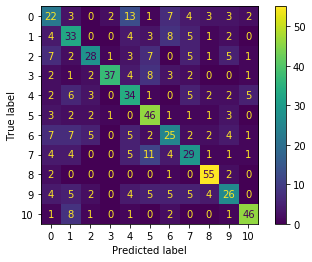

In [38]:
plot_confusion_matrix(clfLogTf, x_test, testRaw_labels)
plt.show()

In [30]:
svd = TruncatedSVD(n_components = 5, random_state = 1)
svc_x = svd.fit_transform(x)
svc_x_test = svd.transform(x_test)

In [27]:
#Try tf-idf svm:
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
svcTf = svm.SVC() 
svcTf.fit(svc_x,trainRaw_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [31]:
svcTf.score(svc_x_test, testRaw_labels)

0.3166713734349995

In [32]:
#try tf-idf multinomial NB:
from sklearn.naive_bayes import MultinomialNB
clfNB = MultinomialNB()
clfNB.fit(x, trainRaw_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:
clfNB.score(x_test, testRaw_labels)

0.5653770121434623

In [186]:
import tensorflow as tf

### Create Model size ###

# laver modellen
model = tf.keras.models.Sequential()
# tilføjer et input på modellen
model.add(tf.keras.layers.Flatten())
# relu er default aktiverings funktion. Lav den om hvis resultatet ikke er godt nok
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
# jeg tilføjer 2 lag til netwærket. Dette er fordi det er en simpel opgave
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
#antallet (10) er antal output. Det er 10 tal i datasettet derfor skal der være et 10 tal
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
#antallet (10) er antal output. Det er 10 tal i datasettet derfor skal der være et 10 tal
model.add(tf.keras.layers.Dense(11, activation=tf.nn.softmax))

# Dette er den mest komplexe del. adam er goto. Hvis der kun er 2 løsninger så brug binary_categorical_crossentropy eller binary_crossentropy i stedet for sparse_categorical_crossentropy
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.fit(X_train, train_labels2, epochs = 8)
# model.fit(X_train, train_labels2, batch_size=64, epochs = 15)

Epoch 1/8
1328/1328 [==============================] - 5s 4ms/step - loss: 1.1192 - accuracy: 0.6315
Epoch 2/8
1328/1328 [==============================] - 4s 3ms/step - loss: 0.8558 - accuracy: 0.7179
Epoch 3/8
1328/1328 [==============================] - 5s 3ms/step - loss: 0.7696 - accuracy: 0.7461
Epoch 4/8
1328/1328 [==============================] - 5s 4ms/step - loss: 0.7024 - accuracy: 0.7659
Epoch 5/8
1328/1328 [==============================] - 5s 4ms/step - loss: 0.6488 - accuracy: 0.7817
Epoch 6/8
1328/1328 [==============================] - 5s 4ms/step - loss: 0.6017 - accuracy: 0.7987
Epoch 7/8
1328/1328 [==============================] - 5s 4ms/step - loss: 0.5613 - accuracy: 0.8127
Epoch 8/8
1328/1328 [==============================] - 5s 4ms/step - loss: 0.5190 - accuracy: 0.8243


In [187]:
val_loss, val_acc = model.evaluate(X_test,test_labels)
print(val_loss, val_acc)


332/332 [==============================] - 1s 3ms/step - loss: 1.0712 - accuracy: 0.6988
1.0712201595306396 0.698766827583313
